## Semantic Segmentation using U-Net on Cricket Dataset

**Author: Abhishek Dey**

### Import Libraries

In [1]:
import os
import os
import glob
import json
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


### Utils

In [2]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

### Dataset Class

In [3]:
class CricketSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, class_map_path=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(glob.glob(os.path.join(images_dir, "*.png")))
        self.transform = transform

        # Load class mapping
        with open(class_map_path, "r") as f:
            data = json.load(f)

        self.color_to_class = {hex_to_rgb(entry["color"]): idx for idx, entry in enumerate(data)}
        self.idx_to_name = {idx: entry["name"] for idx, entry in enumerate(data)}
        self.class_colors = [hex_to_rgb(entry["color"]) for entry in data]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path)
        mask_name = img_name.replace(".png", ".png___fuse.png")
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))

        # Convert mask RGB → class indices
        class_mask = np.zeros(mask.shape[:2], dtype=np.int64)
        for color, class_id in self.color_to_class.items():
            matches = np.all(mask == color, axis=-1)
            class_mask[matches] = class_id

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=img, mask=class_mask)
            img, class_mask = augmented["image"], augmented["mask"]

        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2,0,1).float()      # [H,W,C] -> [C,H,W]
        class_mask = torch.from_numpy(class_mask).long()        # [H,W]

        return img, class_mask

### Datasets & Dataloaders

In [4]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),  # SMP expects images normalized
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
])

# ----- Dataset & DataLoader -----
root = "./cricket_dataset"

train_dataset = CricketSegmentationDataset(
    os.path.join(root, "train/images"),
    os.path.join(root, "train/masks"),
    transform=train_transform,
    class_map_path=os.path.join(root, "classes.json")
)

val_dataset = CricketSegmentationDataset(
    os.path.join(root, "val/images"),
    os.path.join(root, "val/masks"),
    transform=val_transform,
    class_map_path=os.path.join(root, "classes.json")
)

test_dataset = CricketSegmentationDataset(
    os.path.join(root, "test/images"),
    os.path.join(root, "test/masks"),
    transform=val_transform,
    class_map_path=os.path.join(root, "classes.json")
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# ----- Sanity check -----
images, masks = next(iter(train_loader))
print("Image batch:", images.shape)  # [B,3,H,W]
print("Mask batch:", masks.shape)    # [B,H,W]

Image batch: torch.Size([8, 3, 256, 256])
Mask batch: torch.Size([8, 256, 256])


### Dataset Size

In [5]:
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 208
Val size: 29
Test size: 61


### Visualise sample data

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_random_samples(dataset, num_samples=4):
    """
    Visualize random images and corresponding masks from a dataset.

    Args:
        dataset: CricketSegmentationDataset (must have .class_colors attribute).
        num_samples (int): Number of random samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)

    # Convert dataset class_colors to numpy array of dtype uint8
    class_colors = np.array(dataset.class_colors, dtype=np.uint8)

    plt.figure(figsize=(12, num_samples * 3))
    
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        # Convert image and mask to numpy arrays if they are tensors
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()

        # Convert image from [C,H,W] to [H,W,C] if needed
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        # Normalize image to [0,1] for plotting
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Create a color mask using dataset colors
        color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for cls in range(len(class_colors)):
            color_mask[mask == cls] = class_colors[cls]

        # Plot image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image.astype(np.float32))
        plt.axis("off")
        plt.title(f"Image {idx}")

        # Plot mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(color_mask)
        plt.axis("off")
        plt.title(f"Mask {idx}")

    plt.tight_layout()
    plt.show()


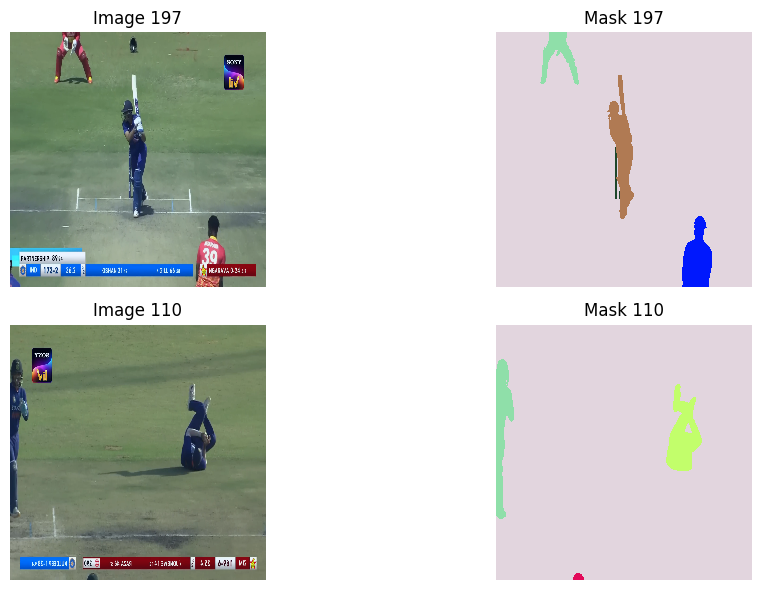

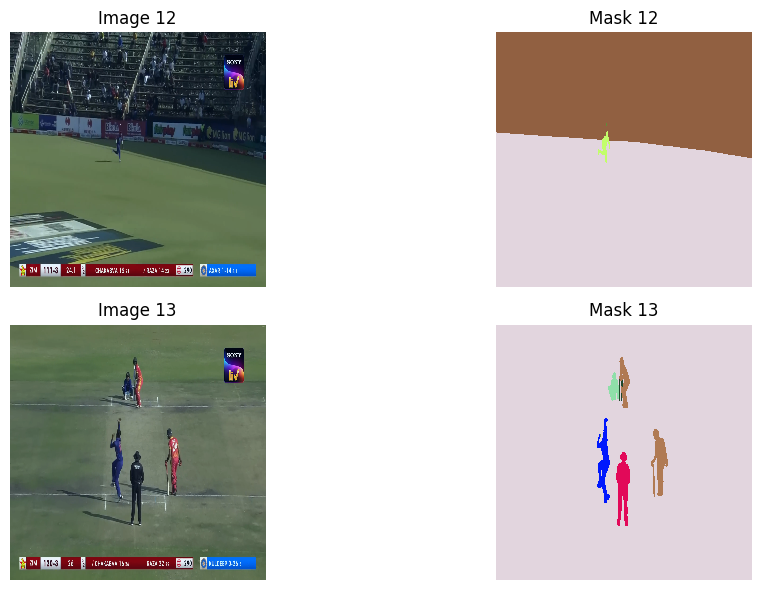

In [7]:
visualize_random_samples(train_dataset, num_samples=2)
visualize_random_samples(val_dataset, num_samples=2)
#visualize_random_samples(test_dataset, num_samples=2)

## Training and validation loops

In [8]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    return epoch_loss / len(loader)


def validate_one_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            epoch_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})
    return epoch_loss / len(loader)


### Model Setup

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

num_classes = 9
batch_size = 16
epochs = 100
lr = 1e-3

ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Model
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=num_classes,
    activation=None
).to(device)

# Loss & Optimizer
loss_fn = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- Save best model ---
best_val_loss = float("inf")
best_model_path = "./best_unet_model.pth"


Using device: cuda


### Model Training

In [10]:
train_losses = []
val_losses   = []

for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}] -----------------------------")

    # ---- Train & Validate ----
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss   = validate_one_epoch(model, val_loader, loss_fn, device)

    # ---- Save history ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # ---- Save best model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model at epoch {epoch+1} with val_loss={val_loss:.4f}")

print(f"\nTraining complete. Best model saved to {best_model_path}")



Epoch [1/100] -----------------------------


Train Loss: 0.8738  Val Loss: 0.8474
✅ Saved best model at epoch 1 with val_loss=0.8474

Epoch [2/100] -----------------------------


Train Loss: 0.7620  Val Loss: 0.7668
✅ Saved best model at epoch 2 with val_loss=0.7668

Epoch [3/100] -----------------------------


Train Loss: 0.6713  Val Loss: 0.6246
✅ Saved best model at epoch 3 with val_loss=0.6246

Epoch [4/100] -----------------------------


Train Loss: 0.6317  Val Loss: 0.6147
✅ Saved best model at epoch 4 with val_loss=0.6147

Epoch [5/100] -----------------------------


Train Loss: 0.5863  Val Loss: 0.5626
✅ Saved best model at epoch 5 with val_loss=0.5626

Epoch [6/100] -----------------------------


Train Loss: 0.5672  Val Loss: 0.5256
✅ Saved best model at epoch 6 with val_loss=0.5256

Epoch [7/100] -----------------------------


Train Loss: 0.5394  Val Loss: 0.5987

Epoch [8/100] -----------------------------


Train Loss: 0.5384  Val Loss: 0.4901
✅ Saved best model at epoch 8 with val_loss=0.4901

Epoch [9/100] -----------------------------


Train Loss: 0.5139  Val Loss: 0.5111

Epoch [10/100] -----------------------------


Train Loss: 0.5027  Val Loss: 0.4748
✅ Saved best model at epoch 10 with val_loss=0.4748

Epoch [11/100] -----------------------------


Train Loss: 0.4848  Val Loss: 0.4648
✅ Saved best model at epoch 11 with val_loss=0.4648

Epoch [12/100] -----------------------------


Train Loss: 0.4796  Val Loss: 0.4290
✅ Saved best model at epoch 12 with val_loss=0.4290

Epoch [13/100] -----------------------------


Train Loss: 0.4753  Val Loss: 0.4328

Epoch [14/100] -----------------------------


Train Loss: 0.4484  Val Loss: 0.4512

Epoch [15/100] -----------------------------


Train Loss: 0.4302  Val Loss: 0.4364

Epoch [16/100] -----------------------------


Train Loss: 0.4171  Val Loss: 0.5135

Epoch [17/100] -----------------------------


Train Loss: 0.4193  Val Loss: 0.3918
✅ Saved best model at epoch 17 with val_loss=0.3918

Epoch [18/100] -----------------------------


Train Loss: 0.3952  Val Loss: 0.4129

Epoch [19/100] -----------------------------


Train Loss: 0.3840  Val Loss: 0.4055

Epoch [20/100] -----------------------------


Train Loss: 0.3805  Val Loss: 0.3949

Epoch [21/100] -----------------------------


Train Loss: 0.3776  Val Loss: 0.3990

Epoch [22/100] -----------------------------


Train Loss: 0.3897  Val Loss: 0.3844
✅ Saved best model at epoch 22 with val_loss=0.3844

Epoch [23/100] -----------------------------


Train Loss: 0.3956  Val Loss: 0.4308

Epoch [24/100] -----------------------------


Train Loss: 0.3732  Val Loss: 0.3966

Epoch [25/100] -----------------------------


Train Loss: 0.3722  Val Loss: 0.3957

Epoch [26/100] -----------------------------


Train Loss: 0.3703  Val Loss: 0.3875

Epoch [27/100] -----------------------------


Train Loss: 0.3742  Val Loss: 0.4003

Epoch [28/100] -----------------------------


Train Loss: 0.3725  Val Loss: 0.4013

Epoch [29/100] -----------------------------


Train Loss: 0.3704  Val Loss: 0.4012

Epoch [30/100] -----------------------------


Train Loss: 0.3502  Val Loss: 0.3497
✅ Saved best model at epoch 30 with val_loss=0.3497

Epoch [31/100] -----------------------------


Train Loss: 0.3312  Val Loss: 0.3642

Epoch [32/100] -----------------------------


Train Loss: 0.3297  Val Loss: 0.3545

Epoch [33/100] -----------------------------


Train Loss: 0.3376  Val Loss: 0.3724

Epoch [34/100] -----------------------------


Train Loss: 0.3216  Val Loss: 0.3511

Epoch [35/100] -----------------------------


Train Loss: 0.3352  Val Loss: 0.3511

Epoch [36/100] -----------------------------


Train Loss: 0.3210  Val Loss: 0.3734

Epoch [37/100] -----------------------------


Train Loss: 0.3205  Val Loss: 0.3507

Epoch [38/100] -----------------------------


Train Loss: 0.3178  Val Loss: 0.3735

Epoch [39/100] -----------------------------


Train Loss: 0.3207  Val Loss: 0.3678

Epoch [40/100] -----------------------------


Train Loss: 0.3156  Val Loss: 0.3621

Epoch [41/100] -----------------------------


Train Loss: 0.3011  Val Loss: 0.3579

Epoch [42/100] -----------------------------


Train Loss: 0.2988  Val Loss: 0.3448
✅ Saved best model at epoch 42 with val_loss=0.3448

Epoch [43/100] -----------------------------


Train Loss: 0.2930  Val Loss: 0.3499

Epoch [44/100] -----------------------------


Train Loss: 0.2749  Val Loss: 0.3552

Epoch [45/100] -----------------------------


Train Loss: 0.2834  Val Loss: 0.3511

Epoch [46/100] -----------------------------


Train Loss: 0.3115  Val Loss: 0.3703

Epoch [47/100] -----------------------------


Train Loss: 0.3041  Val Loss: 0.3461

Epoch [48/100] -----------------------------


Train Loss: 0.2902  Val Loss: 0.3377
✅ Saved best model at epoch 48 with val_loss=0.3377

Epoch [49/100] -----------------------------


Train Loss: 0.2956  Val Loss: 0.3188
✅ Saved best model at epoch 49 with val_loss=0.3188

Epoch [50/100] -----------------------------


Train Loss: 0.2787  Val Loss: 0.3272

Epoch [51/100] -----------------------------


Train Loss: 0.2561  Val Loss: 0.3443

Epoch [52/100] -----------------------------


Train Loss: 0.2759  Val Loss: 0.3278

Epoch [53/100] -----------------------------


Train Loss: 0.2671  Val Loss: 0.3254

Epoch [54/100] -----------------------------


Train Loss: 0.2668  Val Loss: 0.3512

Epoch [55/100] -----------------------------


Train Loss: 0.2530  Val Loss: 0.3103
✅ Saved best model at epoch 55 with val_loss=0.3103

Epoch [56/100] -----------------------------


Train Loss: 0.2573  Val Loss: 0.3087
✅ Saved best model at epoch 56 with val_loss=0.3087

Epoch [57/100] -----------------------------


Train Loss: 0.2540  Val Loss: 0.3189

Epoch [58/100] -----------------------------


Train Loss: 0.2472  Val Loss: 0.3241

Epoch [59/100] -----------------------------


Train Loss: 0.2574  Val Loss: 0.3306

Epoch [60/100] -----------------------------


Train Loss: 0.2531  Val Loss: 0.3300

Epoch [61/100] -----------------------------


Train Loss: 0.2292  Val Loss: 0.3224

Epoch [62/100] -----------------------------


Train Loss: 0.2368  Val Loss: 0.3141

Epoch [63/100] -----------------------------


Train Loss: 0.2466  Val Loss: 0.2905
✅ Saved best model at epoch 63 with val_loss=0.2905

Epoch [64/100] -----------------------------


Train Loss: 0.2442  Val Loss: 0.2917

Epoch [65/100] -----------------------------


Train Loss: 0.2442  Val Loss: 0.2965

Epoch [66/100] -----------------------------


Train Loss: 0.2336  Val Loss: 0.3087

Epoch [67/100] -----------------------------


Train Loss: 0.2249  Val Loss: 0.2674
✅ Saved best model at epoch 67 with val_loss=0.2674

Epoch [68/100] -----------------------------


Train Loss: 0.2139  Val Loss: 0.2845

Epoch [69/100] -----------------------------


Train Loss: 0.2179  Val Loss: 0.2874

Epoch [70/100] -----------------------------


Train Loss: 0.2099  Val Loss: 0.2949

Epoch [71/100] -----------------------------


Train Loss: 0.2097  Val Loss: 0.3128

Epoch [72/100] -----------------------------


Train Loss: 0.2430  Val Loss: 0.2809

Epoch [73/100] -----------------------------


Train Loss: 0.2292  Val Loss: 0.3292

Epoch [74/100] -----------------------------


Train Loss: 0.2250  Val Loss: 0.2836

Epoch [75/100] -----------------------------


Train Loss: 0.2075  Val Loss: 0.2603
✅ Saved best model at epoch 75 with val_loss=0.2603

Epoch [76/100] -----------------------------


Train Loss: 0.2071  Val Loss: 0.3005

Epoch [77/100] -----------------------------


Train Loss: 0.2073  Val Loss: 0.2674

Epoch [78/100] -----------------------------


Train Loss: 0.2178  Val Loss: 0.2690

Epoch [79/100] -----------------------------


Train Loss: 0.2011  Val Loss: 0.2671

Epoch [80/100] -----------------------------


Train Loss: 0.1912  Val Loss: 0.2993

Epoch [81/100] -----------------------------


Train Loss: 0.1967  Val Loss: 0.2581
✅ Saved best model at epoch 81 with val_loss=0.2581

Epoch [82/100] -----------------------------


Train Loss: 0.1907  Val Loss: 0.2736

Epoch [83/100] -----------------------------


Train Loss: 0.1930  Val Loss: 0.2572
✅ Saved best model at epoch 83 with val_loss=0.2572

Epoch [84/100] -----------------------------


Train Loss: 0.1857  Val Loss: 0.2485
✅ Saved best model at epoch 84 with val_loss=0.2485

Epoch [85/100] -----------------------------


Train Loss: 0.2014  Val Loss: 0.2841

Epoch [86/100] -----------------------------


Train Loss: 0.1991  Val Loss: 0.2927

Epoch [87/100] -----------------------------


Train Loss: 0.2261  Val Loss: 0.3067

Epoch [88/100] -----------------------------


Train Loss: 0.2356  Val Loss: 0.2934

Epoch [89/100] -----------------------------


Train Loss: 0.2254  Val Loss: 0.3334

Epoch [90/100] -----------------------------


Train Loss: 0.2008  Val Loss: 0.3004

Epoch [91/100] -----------------------------


Train Loss: 0.1950  Val Loss: 0.2711

Epoch [92/100] -----------------------------


Train Loss: 0.1847  Val Loss: 0.2748

Epoch [93/100] -----------------------------


Train Loss: 0.1931  Val Loss: 0.2946

Epoch [94/100] -----------------------------


Train Loss: 0.1840  Val Loss: 0.2778

Epoch [95/100] -----------------------------


Train Loss: 0.1826  Val Loss: 0.2614

Epoch [96/100] -----------------------------


Train Loss: 0.1802  Val Loss: 0.2608

Epoch [97/100] -----------------------------


Train Loss: 0.1869  Val Loss: 0.2647

Epoch [98/100] -----------------------------


Train Loss: 0.1847  Val Loss: 0.2731

Epoch [99/100] -----------------------------


Train Loss: 0.1770  Val Loss: 0.2710

Epoch [100/100] -----------------------------


Train Loss: 0.1714  Val Loss: 0.2954

Training complete. Best model saved to ./best_unet_model.pth


### Loss Curves

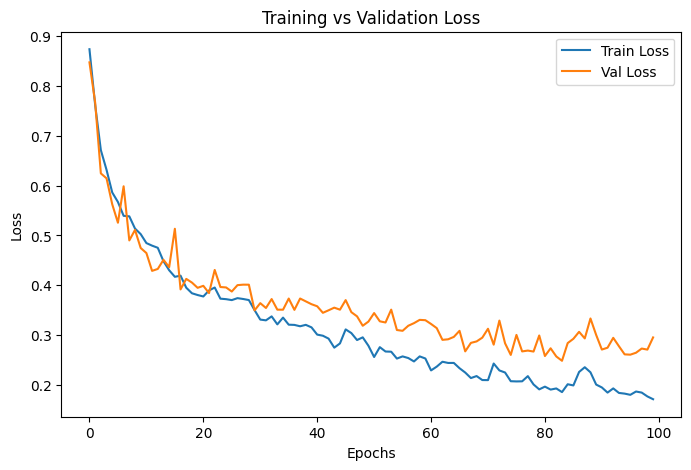

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


### Model Evaluation

In [13]:
import torch
import numpy as np
from tqdm import tqdm

# ----- Metrics -----
def compute_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        if union == 0:
            ious.append(np.nan)  # ignore empty classes
        else:
            ious.append(intersection / union)
    return np.array(ious)


# ----- Load best model -----
best_model_path = "./best_unet_model.pth"
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=len(train_dataset.class_colors),
    activation=None
).to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ Loaded best model from {best_model_path}")

# ----- Predict on test set -----
all_preds, all_gts = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        masks  = masks.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_gts.append(masks.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()  # [N,H,W]
all_gts   = torch.cat(all_gts, dim=0).numpy()    # [N,H,W]

# ----- Compute mean IoU -----
num_classes = len(train_dataset.class_colors)
ious = []
for pred, gt in zip(all_preds, all_gts):
    ious.append(compute_iou(pred, gt, num_classes))
ious = np.array(ious)

mean_ious = np.nanmean(ious, axis=0)
for cls_idx, miou in enumerate(mean_ious):
    print(f"Class {train_dataset.idx_to_name[cls_idx]}: IoU = {miou:.4f}")
print("Mean IoU:", np.nanmean(mean_ious))


✅ Loaded best model from ./best_unet_model.pth


Evaluating: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Class Background: IoU = 0.8040
Class Ground: IoU = 0.9631
Class Bowler: IoU = 0.6216
Class Batsmen: IoU = 0.6772
Class Wicket Keeper: IoU = 0.5408
Class Umpire: IoU = 0.7276
Class Fielder: IoU = 0.5105
Class Ball: IoU = 0.1236
Class Wicket: IoU = 0.2079
Mean IoU: 0.5751366416218926


### Visualize predictions

In [14]:
def visualize_predictions(dataset, preds, num_samples=4):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    class_colors = dataset.class_colors

    plt.figure(figsize=(12, num_samples * 3))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        pred_mask = preds[idx]

        if torch.is_tensor(img):
            img = img.permute(1,2,0).numpy()
            img = (img - img.min()) / (img.max() - img.min())

        # Color masks
        gt_color = np.zeros((*mask.shape,3), dtype=np.uint8)
        pred_color = np.zeros((*mask.shape,3), dtype=np.uint8)
        for cls_idx, color in enumerate(class_colors):
            gt_color[mask==cls_idx] = color
            pred_color[pred_mask==cls_idx] = color

        # Plot
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {idx}")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(gt_color)
        plt.axis("off")
        plt.title("Ground Truth")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_color)
        plt.axis("off")
        plt.title("Prediction")

    plt.tight_layout()
    plt.show()

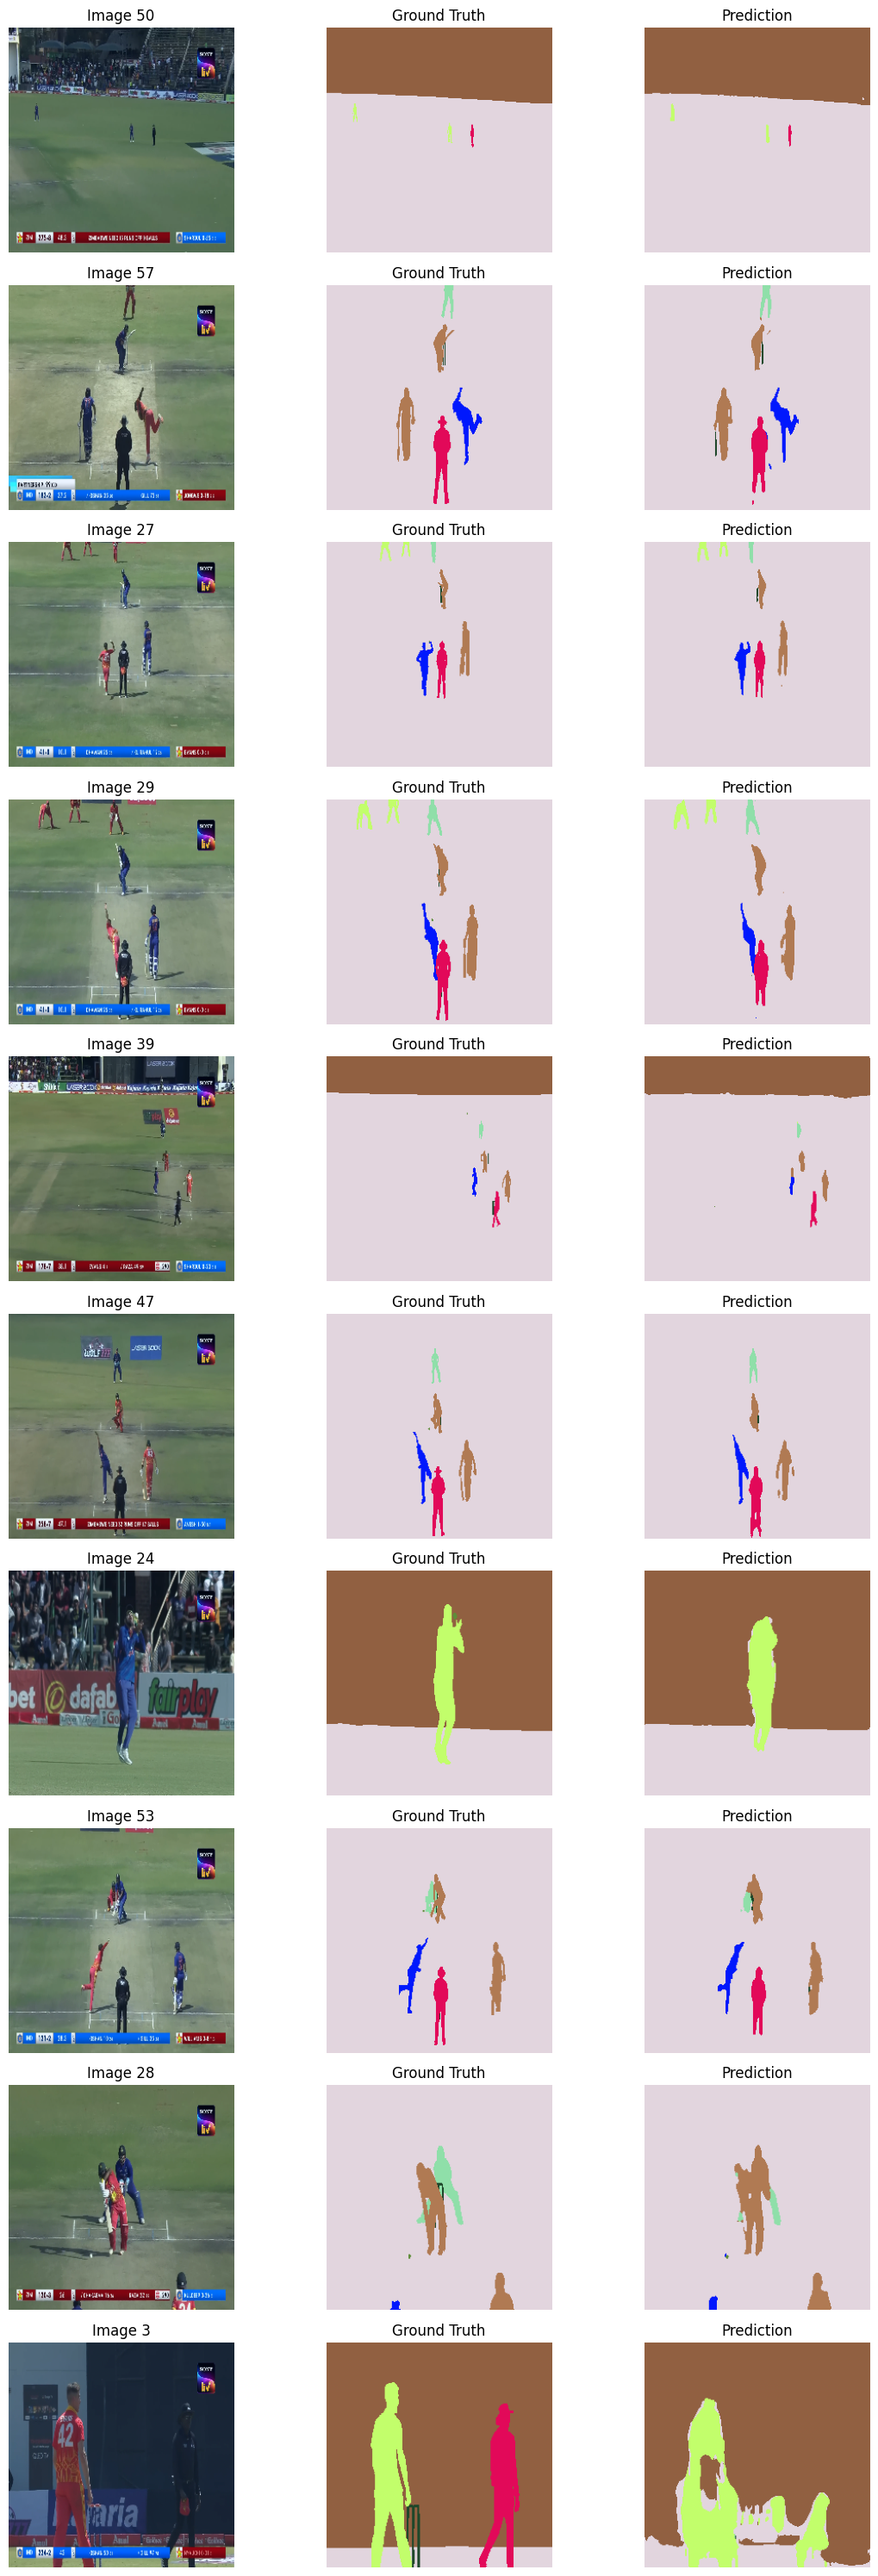

In [15]:
visualize_predictions(test_dataset, all_preds, num_samples=10)